In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlt
import scipy as sp

N=1000
beta= np.c_[ np.array([2,-1,1,3])]
sigma=2
epsilon= np.c_[np.random.normal(0,sigma,N)]
X=np.ones((N,4))
X[:,1]= np.random.normal(2,1,N)
X[:,2]=(2)*np.random.rand(N)-5 
X[:,3]=(-8)*np.random.rand(N)+3
y_star=np.dot(X,beta) +epsilon
y=y_star
for i in range(0,N):
    if y_star[i]<0:
        y[i]=0
yX=np.hstack((y,X))
datax=pd.DataFrame(yX,columns=["Y","X0","X1","X2","X3"])
datax.to_csv("yX_tobit.csv",header=True,index=False)

[[ 1.84720949e+00  9.66661474e-01 -1.28300516e-02  3.73857297e+00
   2.10975774e-01  3.44014279e+00 -2.90086581e-01  4.13221485e+00
   1.37755369e+01]
 [-1.07539760e+00  1.37255782e-01 -1.35856841e+00 -8.28279215e-01
  -1.30435210e+00 -8.62137399e-01 -1.43725314e+00 -7.85263925e-01
   7.92151255e+00]
 [ 9.48006974e-01  2.18818292e-01  5.55296675e-01  1.40341474e+00
   6.05317672e-01  1.31859081e+00  4.96366949e-01  1.51830912e+00
   9.29155675e+00]
 [ 3.06324514e+00  1.42501843e-01  2.83513614e+00  3.32544724e+00
   2.85333691e+00  3.29842608e+00  2.80637147e+00  3.35071058e+00
   5.06134045e+01]
 [ 4.42990766e+00  4.15607180e-01  3.69939444e+00  5.42666969e+00
   3.80163323e+00  5.18484143e+00  3.61937674e+00  5.51640581e+00
   1.23413268e+01]]


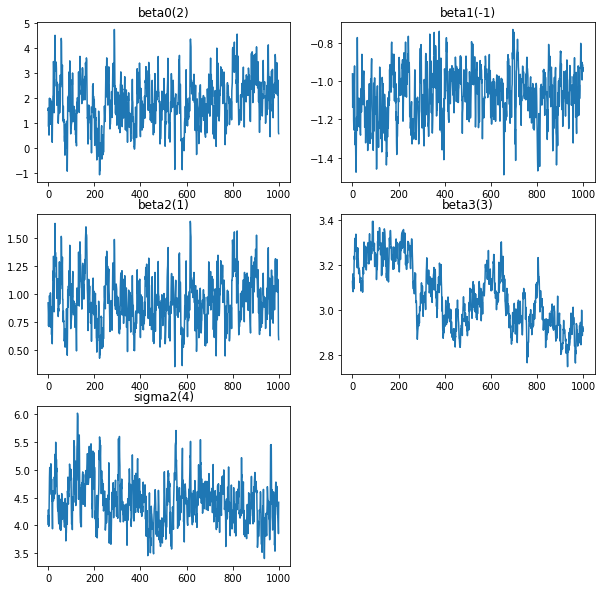

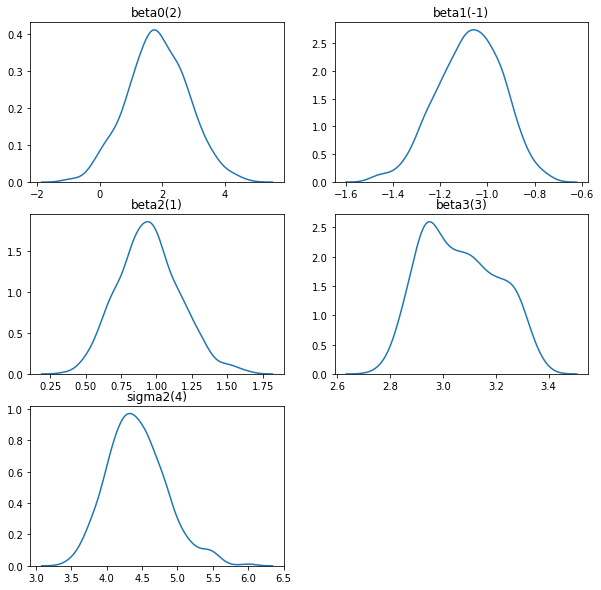

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

def dataread():
    #Read data
    mydata=pd.read_csv("yX_tobit.csv")    
    return mydata
def varname():
    #Name of variables
    names=["beta0(2)", "beta1(-1)", "beta2(1)", "beta3(3)","sigma2(4)"]
    return names
def Inefficiency(posterior):
    #Taken from Prof. Omori's ReportMCMC.ox
    #http://www.omori.e.u-tokyo.ac.jp/MCMC/index.htm
    [R,nvars] =posterior.shape
    Bm = 2*( np.floor( np.sqrt(R) ) +1 )
    Bm=Bm.astype(np.int64)
    #If IF<1, change this value of bandwidth to the value until which the autocorrelation vanishes
    InEf=fTsvar_Batch(posterior, Bm)/np.var(posterior,axis=0)
    return InEf

def fTsvar_Batch(posterior, Bm):
    [R, nvars] =posterior.shape
    M=np.floor(R/Bm)
    M=M.astype(np.int64)
    xbar=np.mean(posterior,axis=0)
    u=np.zeros((M,nvars))
    for i in range(0,M):
        batchx=posterior[i*Bm:(i+1)*Bm,:]
        u[i,:]=np.mean(batchx,axis=0)-xbar
    usq=u*u
    return (Bm/(M-1))*np.sum(usq,axis=0)
             
def report(posterior,names):
    #Save posterior samples
    posterior_df=pd.DataFrame(posterior)
    posterior_df.to_csv("posterior_tobit.csv",header=False,index=False)
    #Report results
    [R,nvars]=posterior.shape
    mean=np.mean(posterior,axis=0)
    sd=np.std(posterior,axis=0)
    p95l=np.percentile(posterior, 2.5, axis=0)
    p95h=np.percentile(posterior, 97.5, axis=0)
    p90l=np.percentile(posterior,5,axis=0)
    p90h=np.percentile(posterior,95,axis=0)
    p99l=np.percentile(posterior,1,axis=0)
    p99h=np.percentile(posterior,99,axis=0)
    
    InEf=Inefficiency(posterior)
    result=np.vstack((mean,sd,p95l,p95h,p90l,p90h,p99l,p99h,InEf)).T
    result_df=pd.DataFrame(result,index=names,columns=["Mean","S.D.","95L**","95H**","90L*","90H*","99L***","99H***","IF"])
    print(result)
    result_df.to_csv("result_tobit.csv")
    #Draw posterior path
    plt.figure(figsize=(10,10))
    for i in range(0,nvars):
        plt.subplot(3,2,i+1)
        plt.plot(posterior[:,i])
        plt.title(names[i])
    plt.savefig("path_tobit.png")
    #Draw posterior density
    plt.figure(figsize=(10,10))
    for i in range(0,nvars):
        plt.subplot(3,2,i+1)
        sns.distplot(posterior[:,i], hist=False, rug=False)
        plt.title(names[i])
    plt.savefig("density_tobit.png")
    return 0
def random_TN(fl_direction,param):
    #Truncated normal random variable generator
    #fl_direction: Flag for direction of trunction
    #=0: Left (x>=a), =1: Right(x<=b), =2: Both( a<=X<=b)
    #NOTE: ONLY RIGHT TRUNCATION IS DEFINED BELOW
    #param[0]: mu, param[1]: sigma2, 
    #param[2]: Left truncation point(for fl_direction=0 or 2), Right tp(for fl=1) 
    #param[3]: Right truncation point(for fl_direction=2)
    mu=param[0]
    sigma=np.sqrt(param[1])
    if fl_direction==0:
        a=param[2]
        p_a=stats.norm.cdf( (a-mu)/sigma,0,1)
        u=np.random.rand(1)
        x=mu+sigma* stats.norm.ppf(u*p_a)
    if fl_direction==1:
        b=param[2]
        p_b=stats.norm.cdf( (b-mu)/sigma,0,1)
        u=np.random.rand(1)
        x=mu+sigma* stats.norm.ppf(u*p_b)
    return x
def main():
    #MCMC primitives
    burnin=1000
    R=1000
    #Read data
    mydata=dataread()
    y=np.c_[np.array(mydata["Y"])]
    X=np.array(mydata[["X0","X1", "X2", "X3"]])
    [N, K]=X.shape
    names=varname()
    
    #Hyperparameters

    mu0=np.zeros((K,1))
    Sigma0=1000*np.eye(K)
    alpha1_0=1
    alpha2_0=1
    
    #Constants repeatedly used in the loop
    invSigma0=np.linalg.inv(Sigma0)
    XX=np.dot(X.T,X)
    alpha1_1=alpha1_0+N/2

    #Initial value
    beta=np.ones((K,1))
    sigma2=1
    y_star=np.c_[np.array(mydata["Y"])]
    # We cannnot use y_star=y here: y is also changed when y_star is changed.

    posterior=np.zeros((R,K+1))

    #MCMC starts
    for i in range(-burnin,R):
        #print(i)
        #Data augmentation for y_star
        Xb=np.dot(X,beta)
        for j in range(0,N):
            if y[j]==0:    
                mu_y=Xb[j]
                mu_y=mu_y[0]
                param_TN=np.array([mu_y,sigma2,0])
                y_star[j]=random_TN(1,param_TN)

        #Gibbs sampling for beta
        Xy=np.c_[np.dot(X.T,y_star)]
        Sigma1=np.linalg.inv(invSigma0+XX/sigma2)
        mu1=np.c_[np.dot(Sigma1,(np.dot(invSigma0,mu0)+Xy/sigma2))]
        beta=np.c_[mu1+np.dot(np.linalg.cholesky(Sigma1),np.c_[np.random.normal(0,1,K)])]
        #Gibbs sampling for sigma2
        u=np.c_[y_star-np.dot(X,beta)]
        alpha2_1=alpha2_0+np.dot(u.T,u)/2
        alpha2_1=alpha2_1[0,0]
        sigma2=1/np.random.gamma(alpha1_1, 1/alpha2_1, 1)
        #Store posterior samples
        if i>=0:
            posterior[i,0:K]=beta.T
            posterior[i,K]=sigma2

    #Report results
    report(posterior,names)
    return 0
if __name__=='__main__':
    
    main()
    


In [25]:
def func(beta,yX):
    K=beta.shape[0]
 #data.shape[0]で列の数
 #data.shape[1]で⾏の数
    y=np.c_[yX[:,0]]
    X=yX[:,1:K+1]
    u=y-np.dot(X, np.c_[beta])
    logL= -np.dot(u.T, u) / 2
    return -logL
theta0=np.array([0.1,0.1,0.1,0.1])
result = sp.optimize.minimize(func, theta0, args=(yX),method='BFGS')
print(result)

      fun: 810.6805339790301
 hess_inv: array([[ 5.33517316e-02, -2.00080083e-03,  1.22178761e-02,
         2.53389570e-05],
       [-2.00080083e-03,  9.57125282e-04, -1.63555656e-05,
         9.78112258e-06],
       [ 1.22178761e-02, -1.63555656e-05,  3.09315234e-03,
        -3.51732051e-05],
       [ 2.53389570e-05,  9.78112258e-06, -3.51732051e-05,
         1.94095833e-04]])
      jac: array([7.62939453e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 54
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([ 2.2402272 , -0.25529461,  0.1857878 ,  0.37396633])


In [ ]:
μ1=